In [1]:
#install dependencies
!pip install patool
!pip install keras_vggface
!pip install keras_applications
!pip install git+https://github.com/rcmalli/keras-vggface.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.8 MB/s eta 0:00:00
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-95ugmtay
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-95ugmtay
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done


In [ ]:
""" path = /usr/local/lib/python3.10/dist-packages/keras_vggface/models.py
In the metioned path replace
(from keras.engine.topology import get_source_inputs)
with
(from keras.utils.layer_utils import get_source_inputs) """

In [4]:
#import required libraries
import requests
import zipfile
import os
import patoolib
import shutil
import cv2
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras_vggface.vggface import VGGFace
from sklearn.cluster import KMeans
from collections import defaultdict
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import rotate

In [4]:
#downloading the  data from the dropbox
!wget -O top20account.zip https://www.dropbox.com/scl/fi/7omlfrp7dbdhatow0f98r/top20account.zip?rlkey=oryn4ulr514vlir8ih6ld27ih&dl=0

--2023-07-12 19:55:25--  https://www.dropbox.com/scl/fi/7omlfrp7dbdhatow0f98r/top20account.zip?rlkey=oryn4ulr514vlir8ih6ld27ih
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/7omlfrp7dbdhatow0f98r/top20account.zip?rlkey=oryn4ulr514vlir8ih6ld27ih [following]
--2023-07-12 19:55:27--  https://www.dropbox.com/e/scl/fi/7omlfrp7dbdhatow0f98r/top20account.zip?rlkey=oryn4ulr514vlir8ih6ld27ih
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca756c5c57c3b41fbdfe12b7b40.dl.dropboxusercontent.com/cd/0/get/B_uJED3-xXzUuM29LAqpTuGrMqQxrQBT6sAK8REwib4_x88bAJ-PeicXy2VTAWDHBjyEU1oPUsy2IBKymOOm_1oju8FhrIYknj8A8BFWDRwCE-f764WVAXrQxHNF9YSQBFY8JPUtVSvLyh-aiKG6Z55hrAmMR-SZ_aOjtTymKSTDSK77GZtWyEBiZCGZ4hdF6Bk/file# [following]

In [5]:
#unzip the data
patoolib.extract_archive("/content/top20account.zip")

patool: Extracting /content/top20account.zip ...
patool: running /usr/bin/7z x -o./Unpack_kviknydw -- /content/top20account.zip
patool: ... /content/top20account.zip extracted to `top20account' (multiple files in root).


'top20account'

###Four steps in an image clustering for social images in an unsupervised fashion:
###(1) Preprocessing images
###(2) Extracting intermediate representations
###(3) Clustering
###(4) Interpreting and validating the clustering results

##1. Preprocessing the Image

In [6]:
#create a new folder 'data' and 'all' inside top20account
os.makedirs("/content/top20account/top20account/data")
os.makedirs("/content/top20account/top20account/all")

#extracting folders of both republicans and democrats to data folder
paths = ["/content/top20account/top20account/D", "/content/top20account/top20account/R"]
for path in paths:
  for filename in os.listdir(path):
    shutil.unpack_archive(path+"/"+filename, "/content/top20account/top20account/data")

In [7]:
#combining all the images to a single folder

data_path = "/content/top20account/top20account/data"
new_dir = "/content/top20account/top20account/all"

for people in os.listdir(data_path):
  for imgs in os.listdir(data_path+"/"+people):
    shutil.move(data_path+"/"+people+"/"+imgs, new_dir+"/"+imgs)

In [2]:
#resizing all images to (128,128,3) for resnet50
path = "/content/top20account/top20account/all"

img_ind = {}
x_128 = []
i=0
for image in os.listdir(path):
    try:
        img = Image.open(path + "/" + image)
        img = img.resize((128, 128))
        x_128.append(np.array(img))
        img_ind[i] = image
        i+=1
    except (IOError, OSError):
        print(f"Skipped invalid image file: {image}")
x_128 = np.array(x_128)
print(x_128.shape)

#converting numpy array to tensor with dtype as float32
x_128 = torch.from_numpy(x_128)
x_128 = x_128.to(torch.float32)
x_reshaped_128 = x_128.permute(0, 3, 1, 2)
mean, std = [0.5,0.5,0.5], [0.5,0.5,0.5]

#normalizing the input tensor
transform_norm = transforms.Compose([
    transforms.Normalize(mean, std)
])

x_norm_res50 = transform_norm(x_reshaped_128)

(12490, 128, 128, 3)


In [ ]:
#resizing all images to (224,224,3) for VggFace model

x_224 = []
for image in os.listdir(path):
    try:
        img = Image.open(path + "/" + image)
        img = img.resize((224, 224))
        x_224.append(np.array(img))
    except (IOError, OSError):
        print(f"Skipped invalid image file: {image}")
x_224 = np.array(x_224)
print(x_224.shape)


#converting numpy array to tensor with dtype as float32
x_224 = torch.from_numpy(x_224)
x_224 = x_224.to(torch.float32)
x_reshaped_224 = x_224.permute(0, 3, 1, 2)
mean, std = [0.5,0.5,0.5], [0.5,0.5,0.5]

#normalizing the input tensor
transform_norm = transforms.Compose([
    transforms.Normalize(mean, std)
])

x_norm_vggface = transform_norm(x_reshaped_224)

Skipped invalid image file: 5391.jpg
(12489, 224, 224, 3)


##2. Extracting low dimensional feature representations

#####The pixel representations of images usually contain redundant information like background objects, light, as well as colors that are all irrelevant for the goal. Therefore mapping pixel representations of an image to an intermediate representation that is low-dimensional removes the redundancies and makes compuatation faster along with preserving the important information.

#####Here we perform feature extraction by taking the results from one of the final hidden layers as feature vectors(low dim represenation).


### Method: Transfer Learning with Resnet50 and VggFace

##### This is helpful since the lower layers in a pretrained model have already “memorized” how to extract basic features from images especially those trained on gigantic datasets like (imagenet, coco) with at least millions of images. The sheer data size allows these models to learn how to extract basic features very well.

##### It also important to know how similar is our data to the one the pretrained models are trained on because if they are different, the models are likely to produce less meaningful representations.

In [ ]:
# Load the pre-trained ResNet-50 model
resnet50 = ResNet50(weights='imagenet', include_top=False)

# Set the model to inference mode
resnet50.trainable = False

# Define the input shape for the feature extractor
input_shape = (128, 128, 3)

# Create an input tensor
inputs = tf.keras.Input(shape=input_shape)

# Get the output tensor of the last convolutional layer
last_conv_layer_output = resnet50.layers[-2].output

# Add an average pooling layer after the last convolutional layer
xnew = GlobalAveragePooling2D()(last_conv_layer_output)

xnew = Flatten()(xnew)

# Create a new model that outputs the features from the last convolutional layer
resnet50 = tf.keras.Model(inputs=resnet50.input, outputs=xnew)

# Reshape the input tensor to match the desired shape
input_tensor = tf.reshape(x_norm_res50, x_128.shape)

# Compute the feature vectors by passing the input tensor through the model
feature_vectors_res50 = resnet50.predict(input_tensor)

# Print the shape of the feature vectors
print("Shape of the feature vectors:", feature_vectors_res50.shape)

# Print the model summary
resnet50.summary()


391/391 [==============================] - 14s 11ms/step
Shape of the feature vectors: (12489, 2048)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']        

##### If we want to cluster dataset with face images, a pretrained model trained on ImageNet may give out less meaningful represenations because ImageNet almost does not contain human classes.
##### Since our dataset consits of images with and without human faces, VggFace model is also used for obtaining the feature vectors.



In [ ]:
# Load the VGG-Face model
vgg_face = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

# Get the output tensor of the last convolutional layer
last_conv_layer_output = vgg_face.layers[-2].output

# Add an average pooling layer after the last convolutional layer
xnew = GlobalAveragePooling2D()(last_conv_layer_output)

# Add a Flatten layer after the average pooling layer
xnew = Flatten()(xnew)

# Create a new model that includes the average pooling and Flatten layers
vgg_face = tf.keras.Model(inputs=vgg_face.input, outputs=xnew)

# Reshape the input tensor to match the desired shape
input_tensor = tf.reshape(x_norm_vggface, x_224.shape)

# Compute the feature vectors by passing the input tensor through the model
feature_vectors_vggface = vgg_face.predict(input_tensor)

# Print the shape of the feature vectors
print("Shape of the feature vectors:", feature_vectors_vggface.shape)

# Print the model summary
vgg_face.summary()

391/391 [==============================] - 6s 13ms/step
Shape of the feature vectors: (12489, 2048)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']    

###Method: Self Supervised with Resnet50

#####This intuition behind self supervised method is to perform:
#####1. Data Augmentation - Here we rotate the images by 90,180,270 degrees to create 4 variations of the image
#####2. Then a standard resnet50 model is trained that takes the augmented dataset as input and classifies different rotations of the same image. Also the features vectors are obtained as the output from the last hidden layer
#####3. Generating pseudo categories - We then apply a k-means clustering algorithm on the feature vectors obtained to group them into K clusters. The new cluster assignment is then used as the new pseudo-category with which fit the supervised model
#####4. We iterate between applying a clustering algorithm on the last hidden layer to generate new cluster labels as pseudo-category, and using pseudo-category to train supervised deep learning models
#####5. Once the iterative process is converged, the initial data is fit to the trained model and the new cluster labels are obtained

#####1. Data Augmentation

In [6]:
#function to rotate an image by 90 degrees
def rotate_images(image, label):
    rotated_image = tf.image.rot90(image, k=label)
    return rotated_image, label

num_rotations = 4 #(0,1,2,3) number of times the image is rotated by 90 degrees
num_images = x_norm_res50.shape[0]
rotated_images = tf.zeros_like(tf.random.normal([1,128,128,3]))
labels = []

#roating each images to 0,90,180,270 degrees and creating a new rotated image tensor
for i in range(num_images):
  for j in range(num_rotations):
    r, l = rotate_images(x_norm_res50[i],j)
    r = tf.reshape(r,[1,128,128,3])
    rotated_images = tf.concat([rotated_images,r],axis=0)
    labels.append(l)
labels = tf.convert_to_tensor(labels)

#####2. Training resnet50 on rotated images

In [10]:
# Load the ResNet50 model
self_super_res50 = ResNet50(include_top=True, weights=None, input_shape=(128, 128, 3), classes=4)

# Compile the model
self_super_res50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
self_super_res50.fit(rotated_images[1:], labels, epochs=5, batch_size=32)

Epoch 1/5
1562/1562 [==============================] - 100s 41ms/step - loss: 0.5323 - accuracy: 0.7998
Epoch 2/5
1562/1562 [==============================] - 66s 42ms/step - loss: 0.3204 - accuracy: 0.8736
Epoch 3/5
1562/1562 [==============================] - 68s 43ms/step - loss: 0.2819 - accuracy: 0.8868
Epoch 4/5
1562/1562 [==============================] - 66s 42ms/step - loss: 0.2561 - accuracy: 0.8956
Epoch 5/5
1562/1562 [==============================] - 64s 41ms/step - loss: 0.2345 - accuracy: 0.9042


In [11]:
self_super_res50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [13]:
# Create a new model that outputs the feature vectors from the last convolutional layer
feature_extractor = tf.keras.Model(inputs=self_super_res50.input, outputs=self_super_res50.layers[-2].output)

# Extract the feature vectors from the last convolutional layer
features_selfsu_res50 = feature_extractor.predict(rotated_images[1:])

print(features_selfsu_res50.shape)

1562/1562 [==============================] - 12s 7ms/step
(49960, 2048)


#####3. Generating pseudo categories follwed by 4.Iterative process

In [15]:
num_iter = 3
n_clusters = 7
features_selfsu_res50n = features_selfsu_res50
kmeans_ssres50 = KMeans(n_clusters=7, random_state=0,n_init='auto')
for i in range(num_iter):
  kmeans_ssres50.fit(features_selfsu_res50n)
  clusters_ssres50 = kmeans_ssres50.labels_
  centers_ssres50 = kmeans_ssres50.cluster_centers_

  self_super_res50n = ResNet50(include_top=True, weights=None, input_shape=(128, 128, 3), classes=n_clusters)
  self_super_res50n.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  self_super_res50n.fit(rotated_images[1:], clusters_ssres50, epochs=5, batch_size=32)

  feature_extractor1 = tf.keras.Model(inputs=self_super_res50.input, outputs=self_super_res50.layers[-2].output)
  features_selfsu_res50n = feature_extractor1.predict(rotated_images[1:])

Epoch 1/5
1562/1562 [==============================] - 103s 42ms/step - loss: 0.6550 - accuracy: 0.7543
Epoch 2/5
1562/1562 [==============================] - 68s 43ms/step - loss: 0.4693 - accuracy: 0.8092
Epoch 3/5
1562/1562 [==============================] - 68s 43ms/step - loss: 0.4299 - accuracy: 0.8209
Epoch 4/5
1562/1562 [==============================] - 67s 43ms/step - loss: 0.3917 - accuracy: 0.8387
Epoch 5/5
1562/1562 [==============================] - 12s 7ms/step
Epoch 1/5
1562/1562 [==============================] - 103s 42ms/step - loss: 0.6438 - accuracy: 0.7549
Epoch 2/5
1562/1562 [==============================] - 69s 44ms/step - loss: 0.4778 - accuracy: 0.8028
Epoch 3/5
1562/1562 [==============================] - 69s 44ms/step - loss: 0.4356 - accuracy: 0.8187
Epoch 4/5
1562/1562 [==============================] - 68s 44ms/step - loss: 0.3839 - accuracy: 0.8369
Epoch 5/5
1562/1562 [==============================] - 11s 7ms/step
Epoch 1/5
1562/1562 [=================

#####5. Predicted labels to the initial data

In [34]:
#getting the clusters labels from recent model
# Reshape the input tensor to match the desired shape
input_tensor1 = tf.reshape(x_norm_res50, x_128.shape)

features_selfsu_res50_ss = feature_extractor1.predict(input_tensor1)

clus_probs = self_super_res50n.predict(input_tensor1)
new_labels = np.argmax(clus_probs, axis=1)

391/391 [==============================] - 3s 8ms/step


##3. Clustering

####Clustering for transfer learning method

In [ ]:
#kmeans clustering resnet 50 feature vectors
kmeans_res50 = KMeans(n_clusters=7, random_state=0,n_init='auto')
kmeans_res50.fit(feature_vectors_res50)

#getting cluster labels for each data point
clusters_res50 = kmeans_res50.labels_

#getting cluster centers
centers_res50 = kmeans_res50.cluster_centers_

In [ ]:
#kmeans clustering vggface feature vectors
kmeans_vggface = KMeans(n_clusters=7, random_state=0,n_init='auto')
kmeans_vggface.fit(feature_vectors_vggface)

#getting cluster labels for each data point
clusters_vggface = kmeans_vggface.labels_

#getting cluster centers
centers_vggface = kmeans_vggface.cluster_centers_

In [ ]:
#hashmap of images to their assigned clusters
img_clusters_res50 = {}
img_clusters_vggface = {}

for i in range(len(clusters_res50)):
  img = img_ind[i]
  img_clusters_res50[img] = clusters_res50[i]
  img_clusters_vggface[img] = clusters_vggface[i]

#find the images in each clusters
imglist_clus_res50 = defaultdict(list)
imglist_clus_vggface = defaultdict(list)

for img,clus in img_clusters_res50.items():
  imglist_clus_res50[clus].append(img)

for img1,clus1 in img_clusters_vggface.items():
  imglist_clus_vggface[clus1].append(img1)

In [ ]:
# Calculate the distance between each point and cluster center
distances_res50 = cdist(feature_vectors_res50, centers_res50, 'euclidean')

distances_vggface = cdist(feature_vectors_vggface, centers_vggface, 'euclidean')

# Find the top 7 closest points to the cluster centers in each cluster
closest_points_res = []
closest_points_vgg = []
closest_imgs_res = defaultdict(list)
closest_imgs_vgg = defaultdict(list)

for i in range(len(centers_res50)):

    # Distances to the cluster center
    cluster_distances_res = distances_res50[:, i]
    cluster_distances_vgg = distances_vggface[:, i]

    # Indices of the 7 closest points
    closest_indices_res = np.argsort(cluster_distances_res)[:7]
    closest_indices_vgg = np.argsort(cluster_distances_vgg)[:7]

    #getting the list of closest images to each cluster
    for j in range(len(closest_indices_res)):

      close_img_res = img_ind[closest_indices_res[j]]               #closest image to the given index
      close_img_clus_res = clusters_res50[closest_indices_res[j]]   #cluster index of the closest image
      closest_imgs_res[close_img_clus_res].append(close_img_res)    #hasmap of cluster to closest images

      close_img_vgg = img_ind[closest_indices_vgg[j]]
      close_img_clus_vgg = clusters_vggface[closest_indices_vgg[j]]
      closest_imgs_vgg[close_img_clus_vgg].append(close_img_vgg)


    # Closest points to the cluster center
    closest_cluster_points_res = feature_vectors_res50[closest_indices_res]
    closest_points_res.append(closest_cluster_points_res)

    closest_cluster_points_vgg = feature_vectors_vggface[closest_indices_vgg]
    closest_points_vgg.append(closest_cluster_points_vgg)

####Clustering for self supervised method

In [35]:
#kmeans clustering resnet 50 self supervised feature vectors
kmeans_res50_ss = KMeans(n_clusters=7, random_state=0,n_init='auto')
kmeans_res50_ss.fit(features_selfsu_res50_ss)

#getting cluster labels for each data point
clusters_res50_ss = kmeans_res50_ss.labels_

#getting cluster centers
centers_res50_ss = kmeans_res50_ss.cluster_centers_

In [42]:
distances_res50_ss = cdist(features_selfsu_res50_ss, centers_res50_ss, 'euclidean')
closest_imgs_res_ss = defaultdict(list)

for i in range(len(centers_res50_ss)):

    # Distances to the cluster center
    cluster_distances_res_ss = distances_res50_ss[:, i]
    # Indices of the 7 closest points
    closest_indices_res_ss = np.argsort(cluster_distances_res_ss)[:7]

    #getting the list of closest images to each cluster
    for j in range(len(closest_indices_res_ss)):

      close_img_res = img_ind[closest_indices_res_ss[j]]               #closest image to the given index
      close_img_clus_res = clusters_res50_ss[closest_indices_res_ss[j]]   #cluster index of the closest image
      closest_imgs_res_ss[close_img_clus_res].append(close_img_res)    #hasmap of cluster to closest images

In [39]:
#hasmap of cluster to images for clusters obtained by self supervised method
clus_img_ss = defaultdict(list)
for i in range(len(clusters_res50_ss)):
  clus_img_ss[clusters_res50_ss[i]].append(img_ind[i])

#random sampling M images in each cluster
cluster_img_ss = {}
for cluster,img_list in clus_img_ss.items():
  random_sample = random.sample(img_list, 7)
  cluster_img_ss[cluster] = random_sample

## 4. Interpreting and Validating the clustering results

### Method: Visualization Through Collated Images

##### The whole collated image represents one clustering solution with each row representing one cluster. Here M images are sampled from each of the K clustering solution and placed in K*M grid. One can sample in two ways:
##### 1. Representative Sampling : Find the top M closest image points to the cluster centers
##### 2. Random Sampling : Find M random image points
##### This method help validate the clustering solutionsby checking if the images in a cluster are indeed formulating a coherent theme


##### We have representative sampling in this method


In [28]:
#visualizing the closest images in each cluster
def visualize_cluster_imgs(cluster_img_dict, grid_size, path):
    num_clusters = len(cluster_img_dict)
    fig, axs = plt.subplots(num_clusters, grid_size, figsize=(12, 8))

    for cluster_idx, lis_image_names in enumerate(cluster_img_dict.values()):
        for img_idx, img_name in enumerate(lis_image_names):
            img = Image.open(path+"/"+img_name)
            img = img.resize((100, 100))  # Adjust image size as per your preference
            img = mpimg.pil_to_array(img)
            axs[cluster_idx, img_idx].imshow(img)
            axs[cluster_idx, img_idx].axis('off')
        axs[cluster_idx, 0].set_ylabel(cluster_idx)
    axs[-1, grid_size // 2].set_xlabel('Images')
    fig.suptitle('Visualization Through Collated Images', fontsize=16)

    plt.tight_layout()
    plt.show()

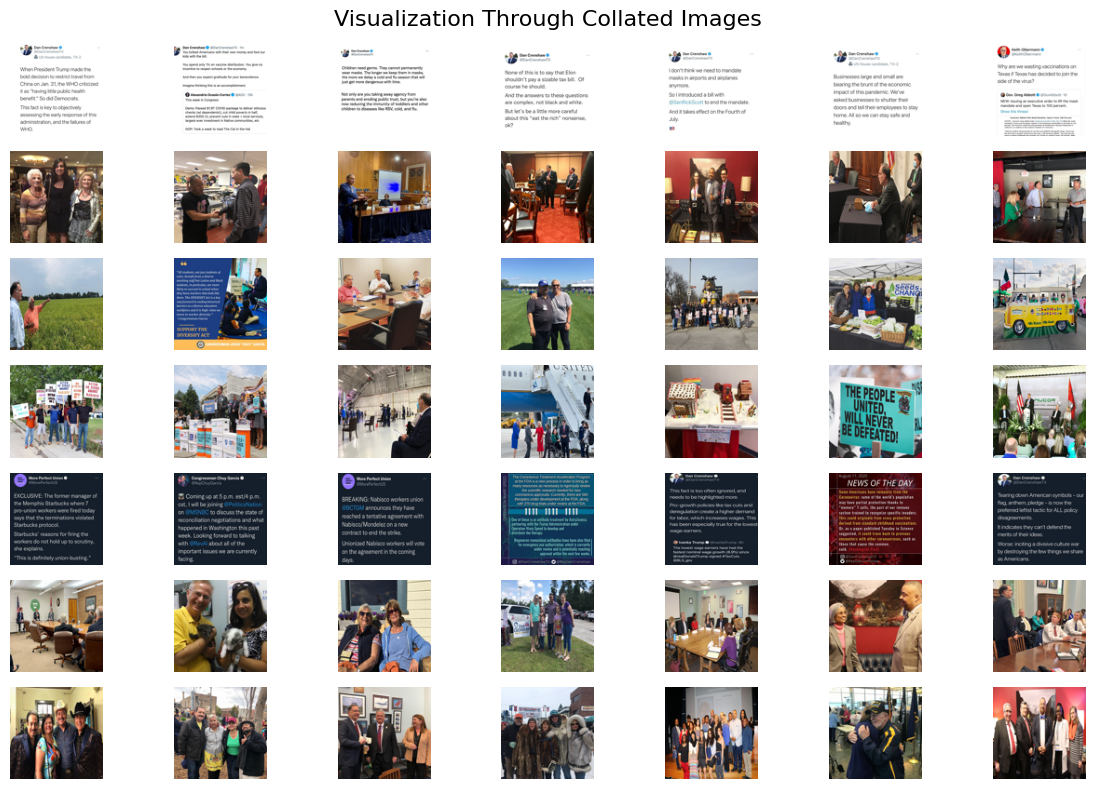

In [ ]:
#visulaizing the clustered images from pretrained resnet50 features
path = "/content/top20account/top20account/all"
grid_size=7
visualize_cluster_imgs(closest_imgs_res, grid_size, path)

#####Interpreting clustering results from pretrained resnet50 features:
##### The cluster 1 clearly groups together all the tweet images and can be named as "tweets". From the images in the cluster 2 we can say the theme can a sort of "meeting". Most of the images in cluster 3 seems to be outdoor. Cluster 4 indicates the outdoot gathering/protest. Clusters 5 shows tweets/messages with dark background. Images in the cluster 6 is combination of gathering/discussion. Most images in Cluster 7 are the "group photos".
##### Therefore the themes/categories that can be decided for each of the clusters are:
#####cluster 1 - tweets, cluster 2 - indoor meeting, cluster 3 - outdoors, cluster 4 - outdoor gathering/protests, cluster 5 - messages with dark background, cluster 6 - gathering/discussion, cluster 7 - group photos


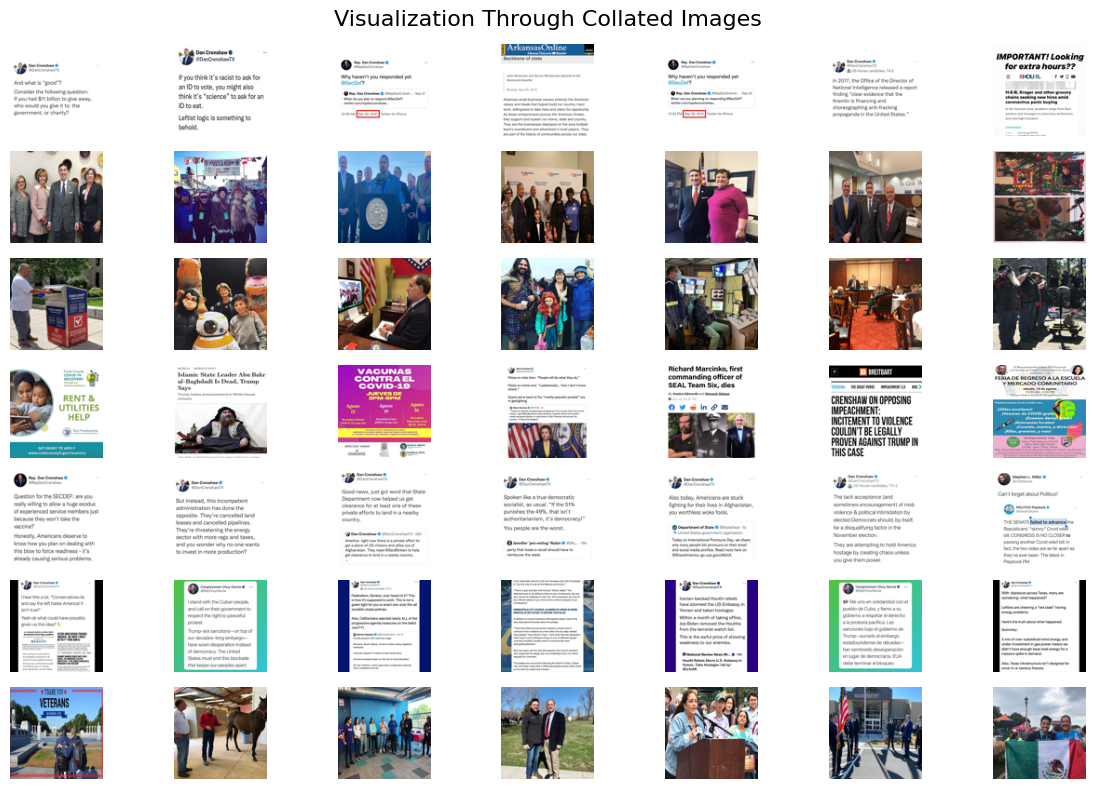

In [ ]:
#visulaizing the clustered images from pretrained vggface features
visualize_cluster_imgs(closest_imgs_vgg, grid_size, path)

#####Similarly the themes/categories for vggface feature vectors are as follows:
##### cluster 1 - highlights/headlines, cluster 2 - group photos,cluster 3 - watching/looking onto something, cluster 4 - posters/advertisements, cluster 5 - tweets, cluster 6 - posts, cluster 7 - standing(most outdoor)

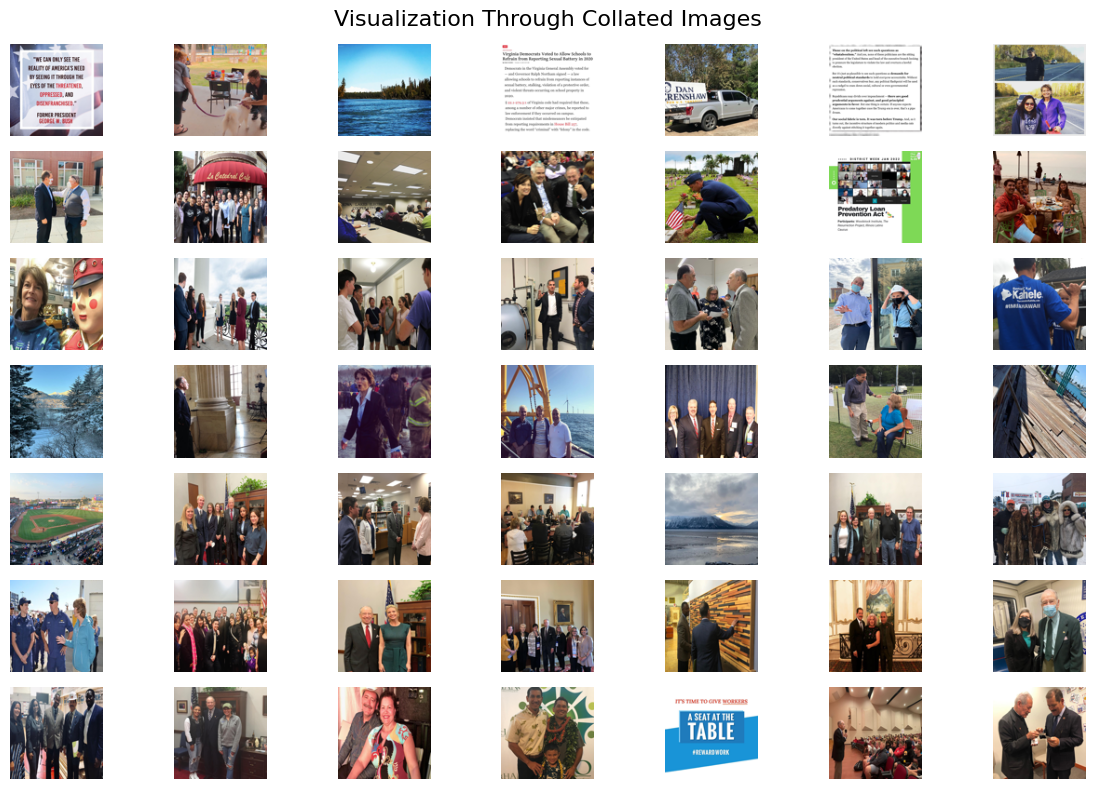

In [40]:
#visulaizing the clustered images from self supervised resnet50 features with random sampling
path = "/content/top20account/top20account/all"
grid_size=7
visualize_cluster_imgs(cluster_img_ss, grid_size, path)

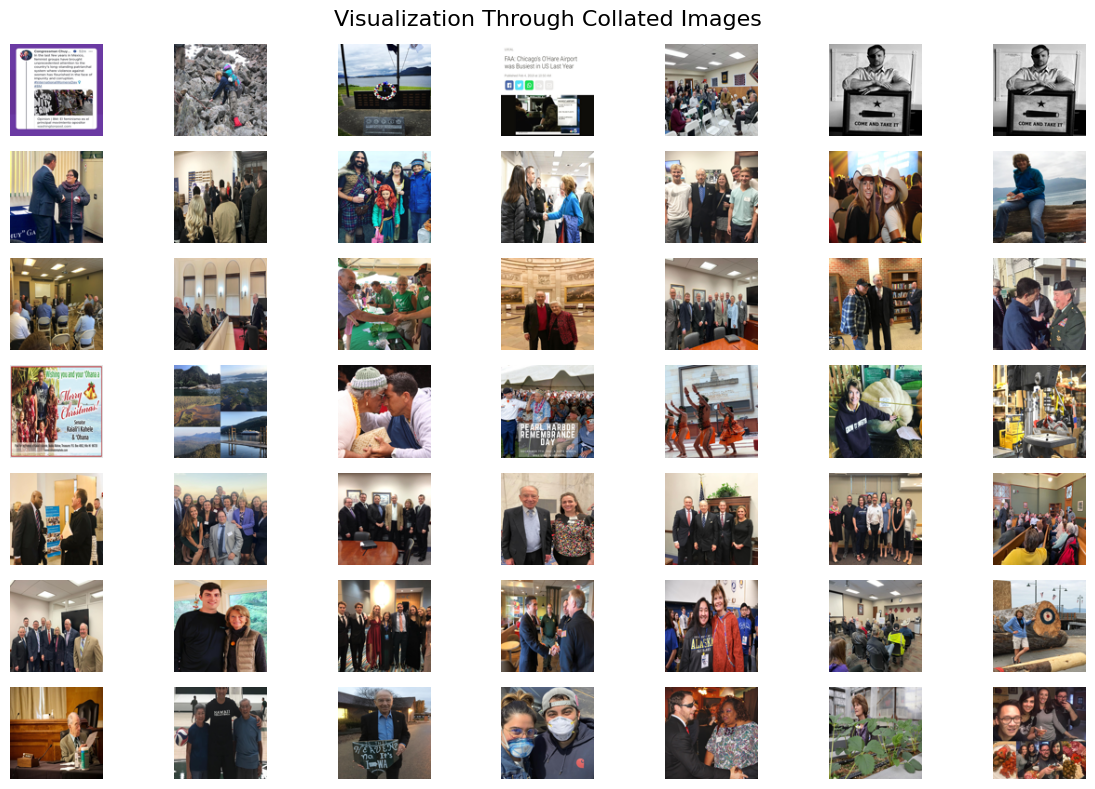

In [43]:
#visulaizing the clustered images from self supervised resnet50 features with representative sampling
visualize_cluster_imgs(closest_imgs_res_ss, grid_size, path)

##### Interpreting clustering results from self supervised resnet features
##### Although model is able to recognise the group photos, public gatherings/discussions to some extent, it is finding to hard to detect similar images and group them. Clearly the model is not as good as the pretrained models discussed earlier

####Findings from the clustering:
##### Considering the results of clustering from all methods the most common topics to look into are office gathering, tweets and discussions.
##### So once we are able to find the common themes we can analyize at the microlevel like:
##### - computing the number of tweets by democrats and republicans
##### - social gatherings, new posted by democrats and republicans
##### - number of protests witnessed
##### With these we can map into the social events that have happend and get cause/resons to them

#### Quantitative Measure "within-cluster" consistency to quantify how well the clustering solutions identify clusters that are internally consistent:
##### 1. Randomly sample M images from each cluster
##### 2. Visual Inspection
##### 3. Theme Assignment - Assign a theme to cluster by finding out the themes from majority images
##### 4. Alpha_j = the within-cluster consistency is the proportionof the images in a given cluster that share the most common label in that cluster

##### The main disadvantage of this method is to assign a theme and validating that to every image in the dataset. For the future work we can find out a faster method for this


####Challenges/Issues:
##### - Dceiding the number of clusters, since the dataset is huge, this consists of variety of images. Needs more time for inspection. For this method used above oit was advised to use clusters between 6-8
##### - Since the dataset is huge, the compuutation requirements are quite high, need more GPUs
##### - Maintaing the data structures from the same framework while preprocessing helps computation to get faster
##### - The RAM was crashing while using PyTorch. Hence was supposed to move to Tensorflow
##### - Not feasible to extract a feature vector with dim more than 4096. If so can use dimsenality reduction techniques
##### - Extracting the image files to  visulize after clustering. For this maintain a dictionary of image names/paths and their indices while converting them to tensor/array. This helps to map the images in the clusters easily
##### - Deciding the resize value for the image. This involves trail and error (compuatation reasons), but better to maintain between 200x200 - 300x300
##### - Major challenge to maintain a code in a modular fashion for scalability and better understanding. This involved more arguments to take care of and integrating each functions/classes will lead to more trail and errors. More time debug as well. So better to use simple comprehensive, compuatationally faster functions, have as little arguments as possible
##### - Deciding the convergence for self supervised method. This impacts the clustering later

####References:
####1. Han Zang and Yilang Peng, "Image Clustering: An Unsupervised Approach to Categorize Visual Data in Social Science Research"
https://journals.sagepub.com/doi/epdf/10.1177/00491241221082603
####2. Mathilde Caron, Piotr Bojanowski, Armand Joulin, and Matthijs Douze, "Deep Clustering for Unsupervised Learning of Visual Features"
https://arxiv.org/pdf/1807.05520.pdf